# Random Forest
Second workhorse of modern ML. Just quick notes, and then implementation. Basically, what is really needed is to understand the decision tree algorithm, both the principles of GBM and Random Forest then becomes quite straight forward.

## Pseudo algorithm
- Bootstrap M sets of data (M = number of trees)
- For each set, fit a decision tree. At each node in the tree, features considered for splitting are randomly selected
- Predictions are then made by averaging the output from the trees, alternatively taking the mode of the set (in classification)

> In my experiments with random forests, bagging is used in tandem with random feature selection. Each new training set is drawn, with replacement, from the original training set. Then a tree is grown on the new training set using
random feature selection.

[Breiman 2001](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)

### Bootstrapping
Sample with replacement from original set, building a new set of equal length. Since you sample with replacement, the odds are that outliers won't appear in many of the bootstrapped sets, which will mean that the variance will decrease in a combined learner.

### Feature Bagging
> Random forests differ in only one way from this general scheme: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features.
>
> [...]
>
> Typically, for a classification problem with p features, √p (rounded down) features are used in each split. For regression problems the inventors recommend p/3 (rounded down) with a minimum node size of 5 as the default.

[Wikipedia](https://en.wikipedia.org/wiki/Random_forest)

### Constructing Trees
Since only subset of features are considered, trees train much faster than for example in GBM, meaning you can have a much higher number of trees without training slowing down.

Extremely Random Forest (ExtraTrees) even sets the splitting point randomly.

#### Using Linear Combinations
> Another approach consists of defining more features by taking random linear combinations of a number of the input variables. That is, a feature is generated by specifying L, the number of variables to be combined.

In [1]:
import sys
sys.path.insert(0, '/Users/freddie.karlbom/dev/algorithms')
from algorithms.decisiontree import DecisionTree
# Importing my custom regression tree class, can be found at
# https://github.com/FreddieK/algorithms-in-python

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.DataFrame(X_train, columns=data.feature_names)
df_train['y'] = y_train

df_test = pd.DataFrame(X_test, columns=data.feature_names)

In [3]:
df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,15.02340,0.0,18.10,0.0,0.6140,5.304,97.3,2.1007,24.0,666.0,20.2,349.48,24.91,12.0
1,0.62739,0.0,8.14,0.0,0.5380,5.834,56.5,4.4986,4.0,307.0,21.0,395.62,8.47,19.9
2,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83,19.4
3,7.05042,0.0,18.10,0.0,0.6140,6.103,85.1,2.0218,24.0,666.0,20.2,2.52,23.29,13.4
4,0.72580,0.0,8.14,0.0,0.5380,5.727,69.5,3.7965,4.0,307.0,21.0,390.95,11.28,18.2


In [4]:
import random

class RandomForestTree(DecisionTree):
    def __init__(self, nr_features = 4, max_depth=15, min_samples=2, **kwargs):
        super(RandomForestTree, self).__init__(max_depth, **kwargs)
        self.nr_features = nr_features

    def _iterate(self, x, y, node, depth=1):
        if depth >= self.max_depth:
            node['value'] = y.mean()[0]
            return
        if len(x) <= self.min_samples:
            node['value'] = y.mean()[0]
            return
        
        best_split = None
        
        # Randomly choose features for tree
        x_subset = random.sample(list(x.columns), self.nr_features)
        for feature in x_subset:
            potential_split = self._find_split(x[feature], x, y)
            if (best_split is None) or \
                (potential_split['SSE'] < best_split['SSE']):
                best_split = potential_split

        # If a branch turned out empty, convert node into leaf
        if len(best_split['left_y']) == 0 or len(best_split['right_y']) == 0:
            node['value'] = y.mean()[0]
            return

        node['feature'] = best_split['feature']
        node['split_point'] = best_split['split_point']
        node['split_SSE'] = best_split['SSE']
        node['depth'] = depth
        node['left'] = {}
        node['right'] = {}

        self._iterate(best_split['left_x'], best_split['left_y'],
                      node['left'], depth + 1)
        self._iterate(best_split['right_x'], best_split['right_y'],
                      node['right'], depth + 1)
        return node

In [5]:
def predict(x):
    predictions = [tree.predict(x) for tree in trees]
    predictions = np.asarray(predictions)
    return np.mean(predictions, axis=0)

In [6]:
nr_trees = 15
training_sets = []
trees = []
mae_train_set = []
mae_test_set = []

# Bootstrapping datasets for trees
for i in range(nr_trees):
    bootstrapped_set = df_train.sample(frac=1.0, replace=True)
    
    y = pd.DataFrame(bootstrapped_set['y'])
    x = pd.DataFrame(bootstrapped_set.drop('y', axis=1))
    
    training_sets.append({
        'x': x,
        'y': y,
    })
    tree = RandomForestTree()
    tree.build_tree(x, y)
    trees.append(tree)
    
    # test if mae decreases as number of trees grows
    y_pred_train = predict(df_train)
    mae_train = np.sum(abs(y_train - y_pred_train)) / len(y_train)
    mae_train_set.append(mae_train)
    
    y_pred_test = predict(df_test)
    mae_test = np.sum(abs(y_test - y_pred_test)) / len(y_test)
    mae_test_set.append(mae_test)
    
    print(f'{i} : Train (MAE): {mae_train:.2f}, Test (MAE): {mae_test:.2f}')

0 : Train (MAE): 1.85, Test (MAE): 2.65
1 : Train (MAE): 1.48, Test (MAE): 2.26
2 : Train (MAE): 1.46, Test (MAE): 2.20
3 : Train (MAE): 1.35, Test (MAE): 2.16
4 : Train (MAE): 1.34, Test (MAE): 2.31
5 : Train (MAE): 1.28, Test (MAE): 2.20
6 : Train (MAE): 1.27, Test (MAE): 2.18
7 : Train (MAE): 1.25, Test (MAE): 2.11
8 : Train (MAE): 1.21, Test (MAE): 2.15
9 : Train (MAE): 1.18, Test (MAE): 2.17
10 : Train (MAE): 1.14, Test (MAE): 2.16
11 : Train (MAE): 1.15, Test (MAE): 2.15
12 : Train (MAE): 1.15, Test (MAE): 2.11
13 : Train (MAE): 1.15, Test (MAE): 2.09
14 : Train (MAE): 1.15, Test (MAE): 2.11


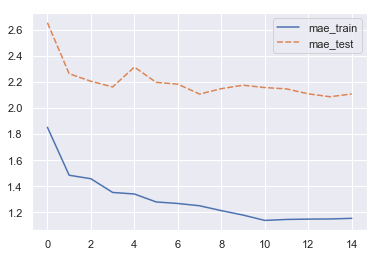

In [29]:
import seaborn as sns
sns.set(style="darkgrid")

plot_data = pd.DataFrame({
    'mae_train': mae_train_set,
    'mae_test': mae_test_set,
})
sns.lineplot(data=plot_data)

## Takeaways
- **Bootstrapping will lessen the variance for the ensemble in RF compared to GBM**, since outliers in the original training set will not get included in all of the bags
- Since the output of trees are averaged in the regression case, **the trees needs to be allowed to grow much deeper (and allow finer splits)** than in GBM in order to produce better individual predictions (and avoid having the results oscillate too wildly). Me limiting of depth here (for training speed) is heavily impacting how good the ensembled model can become
- **Linear combinations of features:** Mentioned briefly in the original paper, but not much elsewhere. Wonder if this is standard behaviour in common implementation?
- I really need to go back over my decisiontree implementation to speed up the construction of trees